# Imports 

In [1]:
import artm
import pandas as pd
from pathlib import Path

In [2]:
from sklearn.metrics import f1_score, accuracy_score

In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
data_dir = Path('.')/'data'
test_data_json_path = data_dir / 'lemmatized_wo_stopwords/test'
train_data_json_path = data_dir / 'lemmatized_wo_stopwords/train'
test_data_path = data_dir / 'test_vw.txt'
train_data_path = data_dir / 'train_vw.txt'

vocab_path = data_dir / 'vocab.txt'
test_bathces_path =  data_dir / 'test_batches'
train_batches_path =  data_dir / 'train_batches'

# Getting data

Consists of class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech 

## Reading

In [11]:
def obtain_vw_format(path_to_file, output_file = 'vw'):
    with open(path_to_file) as f:
        df = pd.read_json(f, lines = True)
    with open(output_file, 'w') as f:
        for index, row in df.iterrows():
            line = f"{index} |@default_class {row['text']} |@title_class {row['title']} "
            if 'label' in df.columns:
                line += f" |@labels_class {row['label']}"
            f.write(line + '\n')
    return df

In [21]:
df_train = obtain_vw_format(train_data_json_path, train_data_path)
df_test = obtain_vw_format(test_data_json_path, test_data_path)


## Batching

In [22]:
batch_vectorizer_test = artm.BatchVectorizer(data_path=str(test_data_path),
                                        data_format='vowpal_wabbit',
                                        target_folder=str(test_bathces_path))

In [23]:
batch_vectorizer_train = artm.BatchVectorizer(data_path=str(train_data_path),
                                        data_format='vowpal_wabbit',
                                        target_folder=str(train_batches_path))

## Building vocabulary 

In [24]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=str(train_batches_path))
dictionary.save_text(str(vocab_path))

# ARTM model

## 1 theme for class

In [60]:
model = artm.ARTM(
    num_topics=4,
    class_ids={
        '@default_class': 1.0,
        '@title_class': 1.0,
        '@labels_class': 1.0},
    seed=42,
    scores=[
        artm.SparsityPhiScore(name='sparsity_phi_score'),
        artm.SparsityThetaScore(name='SparsityTheta'),
        artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
        artm.scores.TopTokensScore(
            name='TopTokensScore', dictionary=dictionary,
                                                   num_tokens=50),
    ],
    regularizers=[
        artm.SmoothSparsePhiRegularizer(
            name='SparsePhi', tau=-0.15
        ),
        artm.SmoothSparseThetaRegularizer(
            name='ThetaSparsifier', tau=-0.15
        ),
        artm.DecorrelatorPhiRegularizer(
            name='decorrelator_phi_def', tau=250, class_ids=['@default_class']
        ),
        artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_title',tau = 250, class_ids=['@bigram_class']),
        artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_lab',tau = 250, class_ids=['@labels_class']),

    ],
)

In [61]:
model.initialize(dictionary)

In [62]:
model.fit_offline(batch_vectorizer=batch_vectorizer_train, num_collection_passes=15)

In [63]:
theta = model.transform(batch_vectorizer=batch_vectorizer_train)
p_cd_test = model.transform(
    batch_vectorizer=batch_vectorizer_train, 
    predict_class_id='@labels_class')
p_cd_test = p_cd_test.T
y_pred = p_cd_test.idxmax(axis=1).astype(int)


print(f"f1_macro = {f1_score(df_train['label'], y_pred, average='macro')}, \
    accuracy = {accuracy_score(df_train['label'], y_pred)}")



f1_macro = 0.25707998193477677,     accuracy = 0.25719166666666665


In [64]:
p_cd_test = model.transform(
    batch_vectorizer=batch_vectorizer_test, 
    predict_class_id='@labels_class')
p_cd_test = p_cd_test.T
y_pred = p_cd_test.idxmax(axis=1).astype(int)


print(f"f1_macro = {f1_score(df_test['label'], y_pred, average='macro')}, \
    accuracy = {accuracy_score(df_test['label'], y_pred)}")



f1_macro = 0.2568836417088359,     accuracy = 0.2569736842105263


In [65]:
for topic_name in model.topic_names:
    print(topic_name + ': ')
    print(model.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['say', 'us', 'reuters', 'new', 'stock', 'price', 'oil', 'company', 'gt', 'inc', 'york', 'percent', 'report', 'year', 'fullquote', 'million', 'investor', 'rise', 'wednesday', 'thursday', 'tuesday', 'monday', 'billion', 'corp', 'sale', 'friday', 'share', 'market', 'target', 'profit', 'fall', 'com', 'http', 'ww', 'href', 'ticker', 'world', 'co', 'reuter', 'bank', 'group', 'cut', 'largest', 'dollar', 'quickinfo', 'aspx', 'month', 'yesterday', 'increase', 'federal']
topic_1: 
['new', 'company', 'say', 'software', 'gt', 'service', 'microsoft', 'quot', 'internet', 'computer', 'use', 'announce', 'technology', 'system', 'inc', 'make', 'search', 'year', 'phone', 'corp', 'online', 'business', 'space', 'music', 'launch', 'web', 'plan', 'security', 'mobile', 'release', 'first', 'com', 'one', 'p', 'wireless', 'user', 'google', 'world', 'could', 'today', 'week', 'million', 'product', 'network', 'offer', 'version', 'ibm', 'next', 'get', 'windows']
topic_2: 
['win', 'game', 'first', 'team', 

given  1-World, 2-Sports, 3-Business, 4-Sci/Tech 

topics:
    - 0 : Business
    - 1 : Sci|Tech
    - 2 : sports
    - 3 : World

In [66]:
labels = ['3', '4', '2', '1']

# Генерация новых документов

In [68]:
def obtain_new_docs(model, labels, num_docs, num_tokens):
    df = pd.DataFrame()
    for topic_name, label in zip(model.topic_names, labels):
        for i in range(num_docs):
            tokens = np.random.choice(model.score_tracker['TopTokensScore'].last_tokens[topic_name], num_tokens)
            text = ' '.join([str(elem) for elem in tokens])
            row = {
                'text' : text,
                'title' : ' '.join([str(elem) for elem in tokens[:5]]),
               # 'ngrams' : get_bigrams(text),
                'label' : label,
            }
            df = df.append(row, ignore_index = True)
    return df

In [69]:
def obtain_vw_format_from_df(df, output_file = 'vw'):
    with open(output_file, 'w') as f:
        for index, row in df.iterrows():
            line = f"{index} |@default_class {row['text']} |@title_class {row['title']}"
            if 'label' in df.columns:
                line += f" |@labels_class {row['label']}"
            #print(line)
            f.write(line + '\n')
    return df

In [70]:
df_train_new = df_train.copy()

In [71]:
augm = obtain_new_docs(model, labels, 10, 10)

In [72]:
df_train_new = df_train_new.append(augm, ignore_index = True)

/home/alina/conda/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [76]:
scores = pd.DataFrame()

In [ ]:
themes = 4
for doc_num in [10, 25, 50, 75, 100, 125, 150, 200]:
    for tok_num in [10, 15, 25, 35, 45]:#[20, 30, 40, 50]:
        df_train_new = df_train.copy()        
        augm = obtain_new_docs(model, labels, doc_num, tok_num)     
        df_train_new = df_train_new.append(augm, ignore_index = True)     
        df_train_new = obtain_vw_format_from_df(df_train_new, train_data_path)
        
        batch_vectorizer_test = artm.BatchVectorizer(data_path=str(test_data_path),
                                        data_format='vowpal_wabbit',
                                        target_folder=str(test_bathces_path))

        batch_vectorizer_train = artm.BatchVectorizer(data_path=str(train_data_path),
                                                data_format='vowpal_wabbit',
                                                target_folder=str(train_batches_path))

        ## Building vocabulary 

        dictionary = artm.Dictionary()
        dictionary.gather(data_path=str(train_batches_path))
        dictionary.save_text(str(vocab_path))

        model = artm.ARTM(
            num_topics=themes,
            class_ids={
                '@default_class': 1.0,
                '@title_class': 1.0,
                '@bigram_class': 1.0,
                '@labels_class': 1.0},
            seed=42,
            scores=[
                artm.SparsityPhiScore(name='sparsity_phi_score'),
                artm.SparsityThetaScore(name='SparsityTheta'),
                artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                artm.scores.TopTokensScore(
                    name='TopTokensScore', dictionary=dictionary,
                                                           num_tokens=50),
            ],
            regularizers=[
                artm.SmoothSparsePhiRegularizer(
                    name='SparsePhi', tau=-0.15
                ),
                artm.SmoothSparseThetaRegularizer(
                    name='ThetaSparsifier', tau=-0.15
                ),
                artm.DecorrelatorPhiRegularizer(
                    name='decorrelator_phi_def', tau=25, class_ids=['@default_class']
                ),
                artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_title',tau = 25, class_ids=['@bigram_class']),
                artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_lab',tau = 25, class_ids=['@labels_class']),
            ],
        )

        model.initialize(dictionary)
        model.fit_offline(batch_vectorizer=batch_vectorizer_train, num_collection_passes=5)

        theta = model.transform(batch_vectorizer=batch_vectorizer_test)
        p_cd_test = model.transform(
            batch_vectorizer=batch_vectorizer_test, 
            predict_class_id='@labels_class')
        p_cd_test = p_cd_test.T
        y_pred = p_cd_test.idxmax(axis=1).astype(int)

        row = {
            'themes': themes,
            'docs': doc_num,
            'terms': tok_num,
            'f1': f1_score(df_test['label'], y_pred, average='macro'),
            'accuracy': accuracy_score(df_test['label'], y_pred),
        }
        print(row)
        
        scores = scores.append(row, ignore_index = True)


In [112]:
scores

,accuracy,docs,f1,terms,themes
0,0.329868,10.0,0.329365,20.0,4.0
1,0.243684,10.0,0.243504,30.0,4.0
2,0.253553,10.0,0.253430,40.0,4.0
3,0.249605,10.0,0.249460,50.0,4.0
4,0.368421,25.0,0.367954,20.0,4.0
...,...,...,...,...,...
67,0.328947,200.0,0.328509,10.0,4.0
68,0.249079,200.0,0.249048,15.0,4.0
69,0.252500,200.0,0.252210,25.0,4.0
70,0.258947,200.0,0.258757,35.0,4.0


In [121]:
scores = scores.sort_values(by = 'terms')

In [132]:
terms_mean = scores.groupby('terms').mean()
terms_std = scores.groupby('terms').std()

In [143]:
np.array(terms_mean['f1'])

array([0.30618235, 0.271008  , 0.27552078, 0.27937265, 0.29700754,
       0.2701146 , 0.34002845, 0.27568269, 0.27214728])

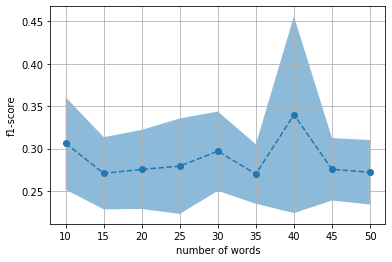

In [148]:
plt.plot(terms_mean.index, terms_mean['f1'], '--o')
plt.fill_between(terms_mean.index, np.array(terms_mean['f1'])-np.array(terms_std['f1']), np.array(terms_mean['f1'])+np.array(terms_std['f1']), alpha = 0.5)
plt.grid(True)
plt.xlabel('number of words')
plt.ylabel('f1-score')
plt.show()

In [ ]:
scores = scores.sort_values(by = 'docs')
docs_mean = scores.groupby('docs').mean()
docs_std = scores.groupby('docs').std()

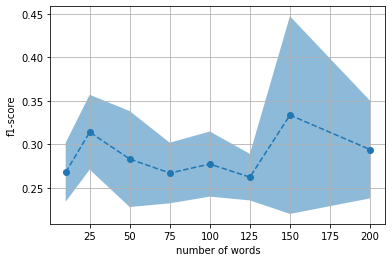

In [147]:
plt.plot(docs_mean.index, docs_mean['f1'], '--o')
plt.fill_between(docs_mean.index, np.array(docs_mean['f1'])-np.array(docs_std['f1']), np.array(docs_mean['f1'])+np.array(docs_std['f1']), alpha = 0.5)
plt.grid(True)
plt.xlabel('number of docs')
plt.ylabel('f1-score')
plt.show()

In [174]:
n = 150
scores = scores.sort_values(by = 'terms')

In [ ]:
plt.plot(scores[scores['docs']==n]['terms'], scores[scores['docs']==n]['f1'], '--o')
plt.grid(True)
plt.xlabel('number of words')
plt.ylabel('f1-score')
plt.show()

In [177]:
m=50

In [178]:
scores = scores.sort_values(by = 'docs')

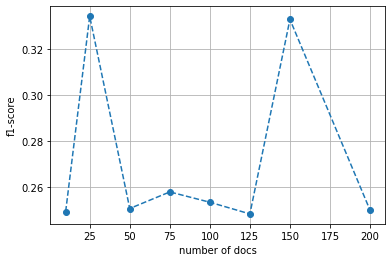

In [179]:
scores = scores.sort_values(by = 'docs')
plt.plot(scores[scores['terms']==m]['docs'], scores[scores['terms']==m]['f1'], '--o')
plt.grid(True)
plt.xlabel('number of docs')
plt.ylabel('f1-score')
plt.show()

In [181]:
scores[scores['docs']==n]

,accuracy,docs,f1,terms,themes
25,0.373553,150.0,0.373189,30.0,4.0
26,0.595395,150.0,0.594630,40.0,4.0
24,0.259474,150.0,0.259429,20.0,4.0
65,0.247368,150.0,0.247309,35.0,4.0
64,0.401184,150.0,0.400677,25.0,4.0
62,0.244605,150.0,0.244531,10.0,4.0
63,0.301053,150.0,0.300785,15.0,4.0
66,0.249868,150.0,0.249663,45.0,4.0
27,0.333158,150.0,0.332806,50.0,4.0
